In [1]:
import gymnasium as gym
import math
import random
import time
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import numpy as np
from tqdm import tqdm
from IPython import display

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

device = 'cpu' # torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
torch.__version__

'2.6.0+cu124'

In [4]:
gym.__version__

'1.0.0'

In [5]:
device

'cpu'

In [6]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

In [7]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [8]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [30]:
# BATCH_SIZE - количество эпизодов, отобранных из буфера воспроизведения
# GAMMA - коэффициент дисконтирования
# EPS_START - начальное значение эпсилон
# EPS_END - конечное значение эпсилон
# EPS_DECAY - скорость экспоненциального спада эпсилон, чем больше - тем медленнее падение
# TAU - скорость обновления целевой сети
# LR - скорость обучения оптимизатора ``AdamW``.

BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.5
LR = 1e-4
FULL_MEMORY_LENGTH = 10000

# Среда
env = gym.make("LunarLander-v3", render_mode="rgb_array")

# Получить число действий
n_actions = env.action_space.n
# Получить число степеней свободы состояний
state, info = env.reset()
n_observations = len(state)

# Инициилизировать сети: целевую и политики
policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)

# Подгрузить в целевую сеть коэффициенты из сети политики
target_net.load_state_dict(policy_net.state_dict())

# Задать оптимайзер
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)

# Инициализировать Replay Memory buffer
memory = ReplayMemory(FULL_MEMORY_LENGTH)

steps_done = 0

# массив длительности эпизода - пойдет в отчет о том, сколько продержался агент
episode_durations = []

In [26]:
# еpsilon-жадная стратегия выбора действия
def select_action(state):
    global steps_done  # глобальный шаги для убывания epsilon
#     случайное значение для определения какой шаг будем делать жадный или случайный
    sample = random.random()
    
#     установка порога принятия решения - уровня epsilon
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    
#     увеличиваем счетчик шагов
    steps_done += 1
    
#     если случайный порог больше epsilon-порога
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

In [27]:
def optimize_model(batch_size: int):
    if len(memory) < batch_size:
        return
    
    # Получить из памяти батч
    transitions = memory.sample(batch_size)
    # Преобразовать его в namedtuple
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                        batch.next_state)), device=device, dtype=torch.bool)
    
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    
    # Собираем батчи для состояний, действий и наград
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(batch_size, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]

    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Объединяем все в общий лосс
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Готовим градиент
    optimizer.zero_grad()
    loss.backward()
    # Обрезаем значения градиента - проблемма исчезающего/взрывающего градиента
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    
    optimizer.step()

In [31]:
if device == 'cuda': # torch.cuda.is_available():
    num_episodes = 2000
else:
    num_episodes = 1000
total_reward = []

for i_episode in tqdm(range(num_episodes)):
    episode_reward = 0
    # Для каждого эпизода инициализируем начальное состояние
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    
    # выполняем действия пока не получим флаг done
    for t in count():
        # выбираем действие [0, 1]
        action = select_action(state)
        # Делаем шаг
        observation, reward, terminated, truncated, _ = env.step(action.item())
        episode_reward += reward

        # Преобразуем в тензор
        reward = torch.tensor([reward], device=device)
        
        # Объединяем done по двум конечным состояниям
        done = terminated or truncated
        
        # присваиваем следующее состояние
        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # отправляем в память
        memory.push(state, action, next_state, reward)

        # переходим на следующее состояние
        state = next_state

        # запускаем обучение сети
        optimize_model(batch_size=128)

        # делаем "мягкое" обновление весов
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)
        
        # Если получили terminated or truncated завершаем эпизод обучения
        if done:
            # добавляем в массив продолжительность эпизода
            episode_durations.append(t + 1)
            total_reward.append(episode_reward)
            break

print('Complete')


100%|██████████| 1000/1000 [1:01:46<00:00,  3.71s/it]

Complete


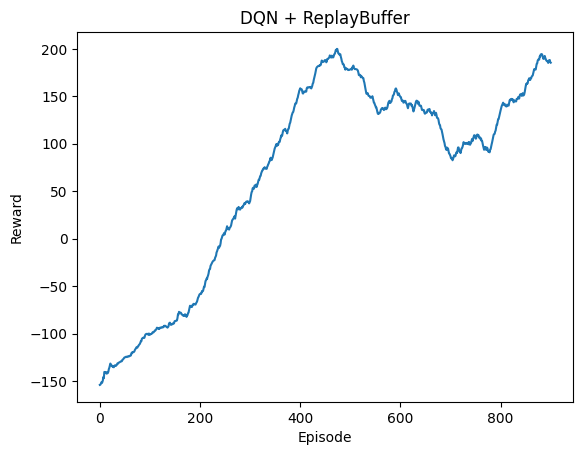

In [24]:
# График обучения при параметре TAU = 0.005

# Вычисление скользящего среднего
window_size = 100
moving_avg = np.convolve(total_reward, np.ones(window_size)/window_size, mode='valid')
plt.plot(moving_avg)
plt.title('DQN + ReplayBuffer')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

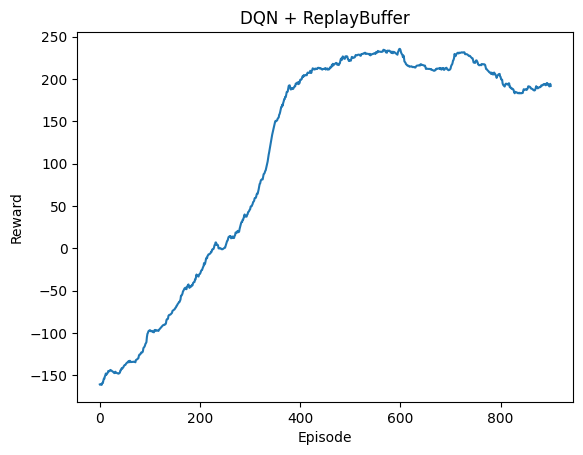

In [29]:
# График обучения при параметре TAU = 0.05

# Вычисление скользящего среднего
window_size = 100
moving_avg = np.convolve(total_reward, np.ones(window_size)/window_size, mode='valid')
plt.plot(moving_avg)
plt.title('DQN + ReplayBuffer')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

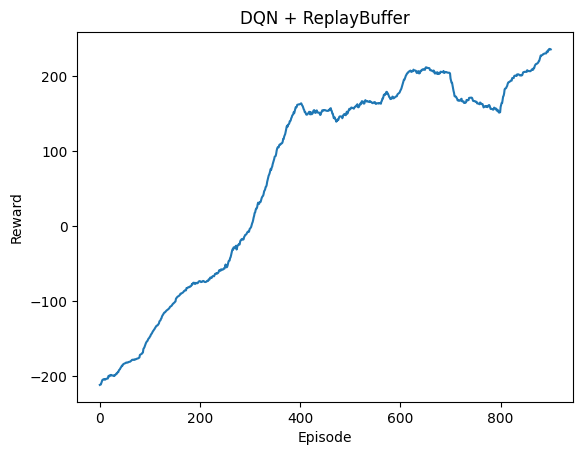

In [32]:
# График обучения при параметре TAU = 0.5

# Вычисление скользящего среднего
window_size = 100
moving_avg = np.convolve(total_reward, np.ones(window_size)/window_size, mode='valid')
plt.plot(moving_avg)
plt.title('DQN + ReplayBuffer')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

In [36]:
# Функция отображения эпизода
def run_episode(env, agent, epsilon, max_steps):
    state, _ = env.reset()
    total_reward = 0
    steps = 0
    img = plt.imshow(env.render())
    while True:
        env.render()  # Отображение окружения
        steps += 1
        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
                q_values = agent(state_tensor)
                action = int(torch.argmax(q_values).item())

        next_state, reward, done, _, _ = env.step(action)
        total_reward += reward

        plt.axis('off')        
        frame = env.render()
        img.set_data(frame)
        display.display(plt.gcf())
        display.clear_output(wait=True)
        time.sleep(0.1)
        
        if done or steps >= max_steps:
            break

        state = next_state

    env.close() # закрываем игровую среду после окончания игры

    return total_reward, steps

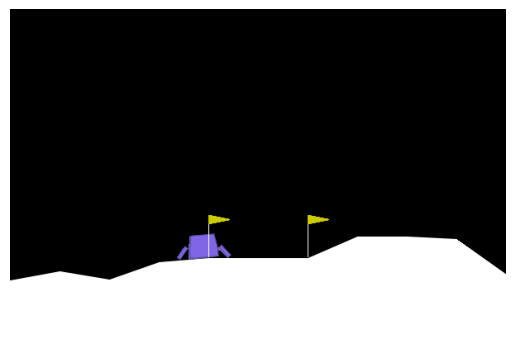

In [39]:
# Отображение эпизода
total_reward, steps = run_episode(env, policy_net, 1, 500)

In [40]:
print(total_reward, steps)

-68.79896108838844 71


In [ ]:
# Выводы
# Для обучения алгоритма потребуется больше 1000 эпизодов
# Наилучшие результаты получены при параметре TAU = 0.05